In [1]:
import os
import sys
from tqdm import tqdm,tnrange
import time
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from music21 import *
#from utilities.constants import *
#from utilities.utilities import *

WORKING_DIR = os.path.abspath("")
SCORES_DIR = os.path.join(WORKING_DIR,"scores")
DIRECTION = "desc"
DISTANCE_TH = 3

# Organise files in documents

In [2]:
def get_all_pitchclassdistribution_df(path, direction = "all", distance_th = 2):
    
    number_of_files = int(sum(1 for _ in os.listdir(path)))

    pitchclass_df = pd.DataFrame()
    
    for score,i in zip(os.listdir(path),tnrange(number_of_files-1)):
        
        _, extension = os.path.splitext(score)
        
        if extension == ".xml":
            
            s = converter.parse(os.path.join(path,score))
            #print("s:",s)
            
            classes,percentage = get_pitch_class_percentage(s, direction, distance_th)
            
            classes = [str(x) for x in classes]
            percentage = [[x] for x in percentage]
            
            tmp_df = pd.DataFrame(dict(zip(classes,percentage)))
            
            pitchclass_df = pd.concat([pitchclass_df,tmp_df],sort = True, ignore_index = True)
            
    return pitchclass_df


In [3]:
def get_pitch_class_percentage(score, direction, distance_th):
    #directions asc = ascendant, desc = descendant, all
    
    pitches = score.parts[0].pitches
    
    #print("pitches:", pitches)
    
    midi_pitches = select_pitches_direction(pitches, direction, distance_th)
    
    count_pitch_classes = defaultdict(int)
    
    for note in midi_pitches:
        count_pitch_classes[int(note%12)] += 1
    
    pitch_classes = sorted(list(count_pitch_classes.keys()))
    data = []
    
    for c in pitch_classes:
        data.append(count_pitch_classes[c])
    
    data = 100*np.array(data)/sum(data)
    
    return pitch_classes, data

In [4]:
def select_pitches_direction(pitches,direction,distance_th):
    
    if not direction in ["all","desc","asc"]:
        raise ValueError('Only all, desc, asc modes accepted')
        
    if distance_th<=0:
        raise ValueError('distance_th must be ≥1')
    
    midi_pitches = [p.ps for p in pitches]
    
    if direction == "all":
        return midi_pitches

    midi_pitches = np.array(midi_pitches)
    
    #print("midi_pitches:", midi_pitches)
    
    difference = np.diff(midi_pitches)
    difference = np.clip(difference, a_min = -1, a_max = 1)
    
    #print("difference:", difference)
    
    state = "null"
    selection = []
    
    for i in range(len(midi_pitches)):
    
        #to be changed... this is a piece of shit
        suma = sum(difference[i:(i+distance_th)])
        if suma == distance_th:
            state = "asc"
        elif suma == -1*distance_th:
            state = "desc"
        
        if state == "asc" and state == direction:
            selection.append(midi_pitches[i])
        elif state == "desc" and state == direction:
            selection.append(midi_pitches[i])
        
        #print(str(midi_pitches[i]) + "," + str(difference[i]) + " suma:" + str(suma) + "state:" + state)
    
    return selection

In [5]:
pitchclass_df = get_all_pitchclassdistribution_df(SCORES_DIR, DIRECTION, distance_th = DISTANCE_TH)

In [10]:
pitchclass_df = pitchclass_df.transpose()
pitchclass_df.index = pitchclass_df.index.astype(int)
pitchclass_df = pitchclass_df.sort_index().transpose().replace(np.nan, 0)
pitchclass_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,12.373159,0.0,19.083470,0.0,12.733224,18.265139,0.000000,15.908347,0.0,13.944354,0.098200,7.594108
1,16.339869,0.0,13.289760,0.0,13.725490,16.230937,0.000000,7.734205,0.0,16.339869,16.339869,0.000000
2,16.804979,0.0,10.892116,0.0,21.991701,15.612033,0.000000,18.879668,0.0,12.085062,0.155602,3.578838
3,11.057471,0.0,14.988506,0.0,27.931034,15.770115,0.114943,15.080460,0.0,8.551724,0.988506,5.517241
4,12.394761,0.0,22.076707,0.0,21.702526,3.928906,2.478952,17.305893,0.0,14.312442,0.327409,5.472404


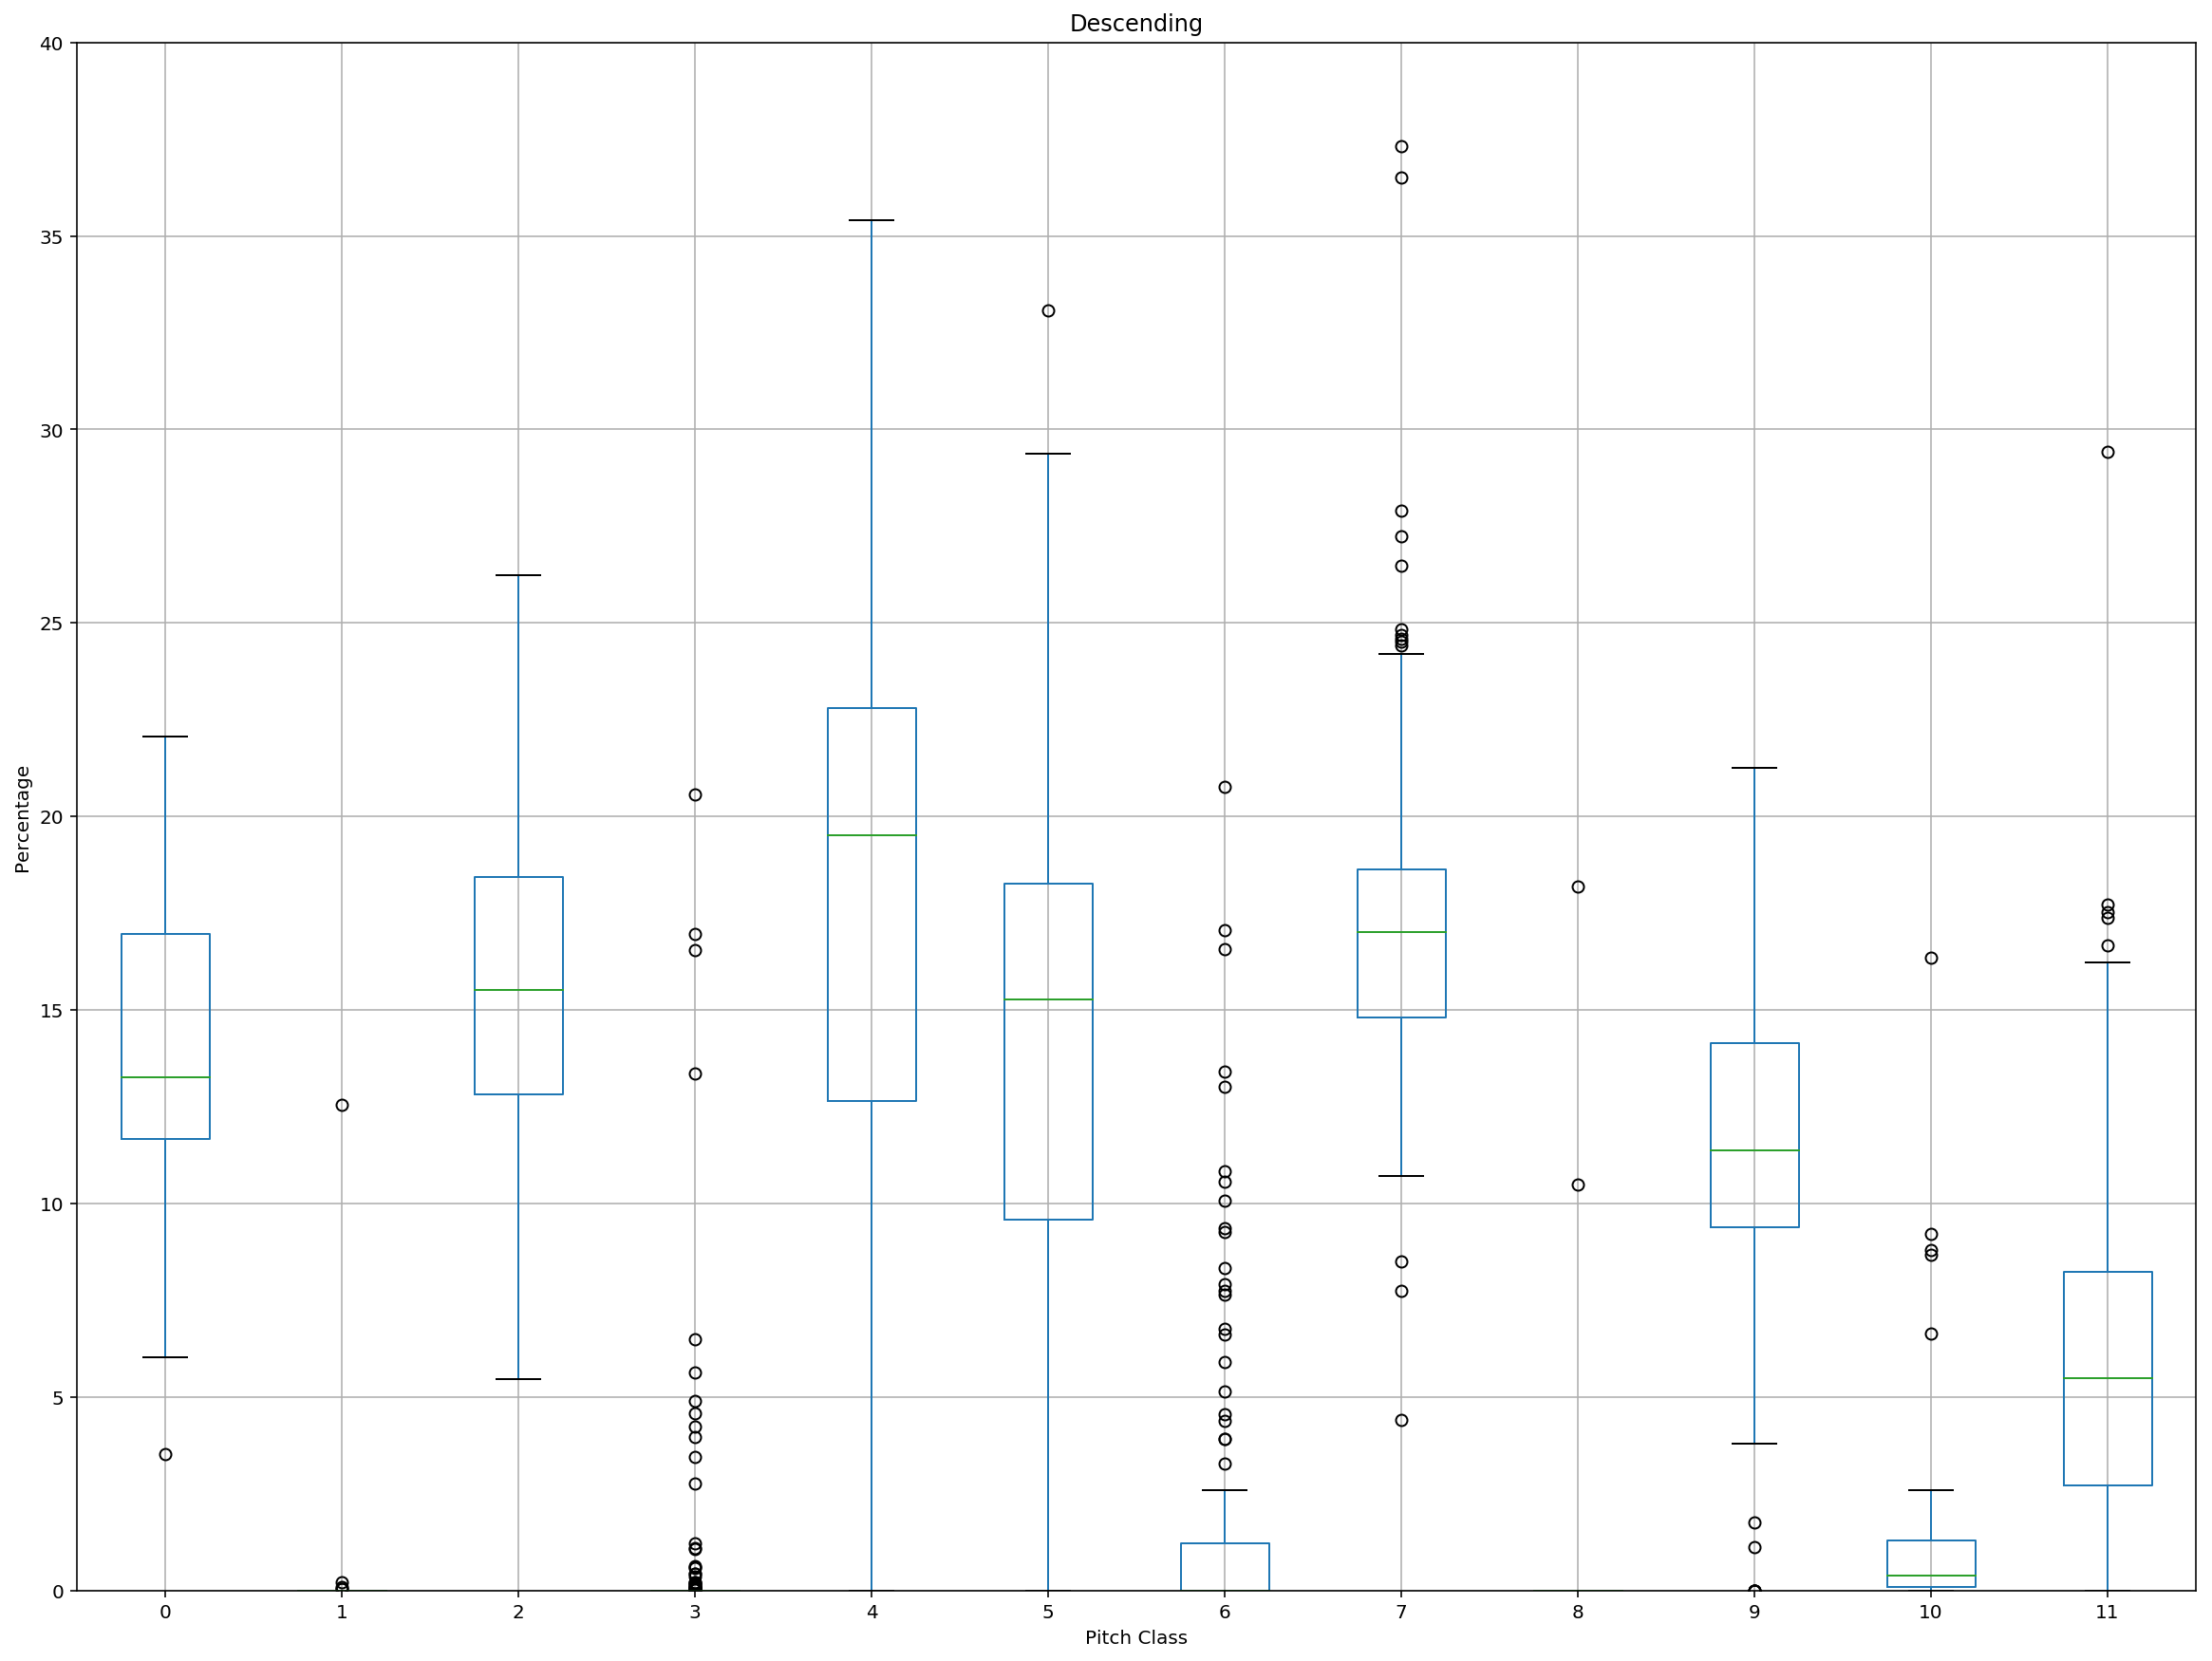

In [7]:
ax = pitchclass_df.boxplot(figsize = (20,15))

plt.xlabel("Pitch Class")
plt.ylabel("Percentage")
plt.ylim(0, 40)

if DIRECTION == "asc":
    plt.title("Ascending")
    filename = "Ascending_{0}_distance.png".format(DISTANCE_TH)
    
elif DIRECTION == "desc":
    plt.title("Descending")
    filename = "Descending_{0}_distance.png".format(DISTANCE_TH)
    
elif DIRECTION == "all":
    plt.title("All")
    filename = "All_{0}_distance.png".format(DISTANCE_TH)
    
plt.savefig(filename)

In [8]:
#print("{0}{1}{2}".format("Formatting files in ", SCORES_DIR, " and storing them in the scores folder..."))

#organize_xml_files(SCORES_DIR)

#print("Done")

In [9]:
#show_music21_settings()